# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from operator import add
from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
def makeItTuple(dataset, index, value):
    if(type(value) == int):
        return dataset.map(lambda x : (x[index], value))
    if(type(value) == str):
        return dataset.map(lambda x : (x[index], x[value]))

What does the data look like?

In [3]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


#### Exercise 3.4

In [4]:
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
# uidOne = ratings.map(lambda x : (x['userId'], 1))
uidOne = makeItTuple(ratings, 'userId', 1)#creates a tuple (userId, 1)
# movidOne = ratings.map(lambda x : (x['movieId'], 1)) 
movidOne = makeItTuple(ratings, 'userId', 1)#creates a tuple (filmId, 1)

#add values of all tuples with same key. Gives tuple (Id, occurences of this userId)
sortUser = sorted(uidOne.reduceByKey(add).collect())
sortMovie = sorted(movidOne.reduceByKey(add).collect())

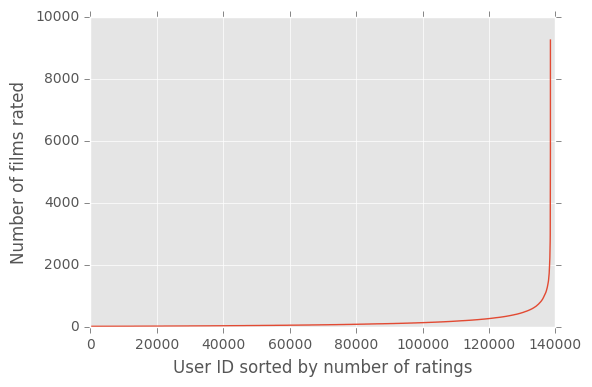

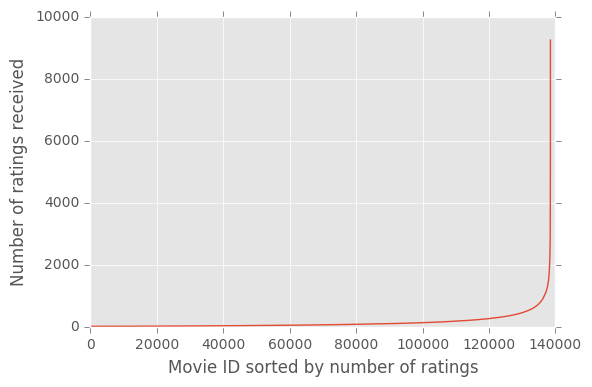

In [5]:
#changes tuples (Id, occurence) to a list of occurences (random order)
tableUsers = np.zeros(len(sortUser))
tableMovies = np.zeros(len(sortMovie))
for i in range(len(sortUser)):
    tableUsers[i] = sortUser[i][1]
for i in range(len(sortMovie)):
    tableMovies[i] = sortMovie[i][1]
    
#Plot data
plt.plot(sorted(tableUsers)) #plot sorted values
plt.xlabel('User ID sorted by number of ratings')
plt.ylabel('Number of films rated')
plt.show();

plt.plot(sorted(tableMovies))
plt.xlabel('Movie ID sorted by number of ratings')
plt.ylabel('Number of ratings received')
plt.show();

We immediately see the distribution is not uniform : some users rated barely a few films (min is around 20), when some others rated more that 9'000 films. 

Same applies for the films. Most films have almost no rating : first 20'000 films have less than 200 ratings and first 4'000 have 1 ratings. On the other hand, a handful of them have tens of thousands.

#### Exercise 3.5

In [6]:
with open("my-ratings.txt", "r") as F: #open file
    newEntries = ",".join(F.read().split("\n")[:-1]) #one string of all entries
data = sc.parallelize(json.loads("["+newEntries+"]")) #interpret string as JSON and make pysparkRDD
joined = ratings.union(data) #fusion the datasets

#separate datasets w.r.t timestamp (~ 20%/80%)
validation = joined.filter(lambda entry : entry["timestamp"]%10 <= 1) 
training = joined.filter(lambda entry : entry['timestamp']%10 > 1)

#Making sure sizes are correct
totalsize = joined.count()
validationsize = validation.count()
trainingsize = training.count()
print("Training set represents", 100*trainingsize/totalsize,"% and validation set represents", 100*validationsize/totalsize, "%")

Training set represents 79.99881901617948 % and validation set represents 20.00118098382052 %


#### Exercise 3.6

In [7]:
##Computing global average
#transform to a list of ratings, then sum and divide by total size
µ = training.map(lambda entry : entry['rating']).fold(0, add)/trainingsize
print("Global average is", µ)

Global average is 3.5255073396015484


In [8]:
##Computing User bias
uid_sumRatings = makeItTuple(training, 'userId', 'rating').reduceByKey(add)
uid_numRatings = makeItTuple(training, 'userId', 1).reduceByKey(add)

user_bias = uid_sumRatings.join(uid_numRatings) #has shape (uid, (sumRatings, numRatings))
user_bias = user_bias.map(lambda x : (x[0], x[1][0]/x[1][1] - µ)); #has shape (uid, alpha)

listUserBias = user_bias.collect()
dicUserBias = dict(listUserBias)

In [9]:
##Computing Remaining Item Bias
def computeBeta(x): 
    sumBias = 0
    sumRating = 0
    for i in x[0][1]: #i = (uid, rating)
        sumBias += dicUserBias[i[0]] #compute sum of bias
        sumRating += i[1] #compute sum of ratings
    return(x[0][0], (sumRating-sumBias)/x[1] - µ) #return tuple (movId, beta)

movId_ratings = training.map(lambda entry : (entry['movieId'], (entry['userId'], entry['rating'])))
item_bias = movId_ratings.groupByKey().map(lambda x : (x, len(x[1]))) #shape ((movId, list(uid, rating)), numRatings)
item_bias = item_bias.map(computeBeta)

listItemBias = item_bias.collect()
dicItemBias = dict(listItemBias)

In [10]:
parameters = training.map(lambda entry : (entry['userId'], 1)).groupByKey().count()+training.map(lambda entry : (entry['movieId'], 1)).groupByKey().count()
print("There are",parameters,"parameters")

There are 164326 parameters


In [11]:
#When there is no value for user bias or item bias we use the average values
avg_item_bias = sum(list(zip(*listItemBias))[1])/len(listItemBias)
avg_user_bias = sum(list(zip(*listUserBias))[1])/len(listUserBias)
def predict_rating(user, movie): 
    userBias = dicUserBias.get(user,avg_user_bias)
    itemBias = dicItemBias.get(movie,avg_item_bias)
    return µ + userBias + item_bias

In [14]:
def toDeltaRating(t):
    """
    takes an entry (uid, movId, rating) as a dictionary and returns the 
    squared difference between the predicted rating and actual rating.
    To be used in a RDD map.
    
    returns a tuple (userId, difference)
    """
    uid = t["userId"]
    movId = t["movieId"]
    rating = t["rating"]
    sqrdDiff = (predict_rating(uid, movId) - rating)**2  
    return (uid,sqrdDiff)
    

def error(dataset): #dataset = RDD of (uid, movId, rating)
    uid_numRatings_ds = makeItTuple(dataset, 'userId', 1).reduceByKey(add)
    ratingSquaredDiff = dataset.map(toDeltaRating) #shape (uid, difference) for specifics uid, movId
    ratingDiffSum = ratingSquaredDiff.reduceByKey(add) #for each uid, sum of squared differences
    perUserError = ratingDiffSum.join(uid_numRatings_ds) #shape (uid, (sumOfSquaredDiff, num))
    perUserError = perUserError.map(lambda x :(x[1][0]/x[1][1])**0.5)
    return perUserError.reduce(add)/len(listUserBias)

In [15]:
# newVal = validation.map(lambda entry : (entry['userId'], entry['movieId'], entry['rating']))
print("The error on our sets is",error(validation))

Exception: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPARK-5063.

As we can see, the error is slightly below the expected. This is probably due to a small 